In [1]:
## do the necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

import dqn_model

from collections import deque
import random
import os

from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from gym import spaces
import pybullet as p

current_dir=/home/akaaku13m/my_env/robot_lab_1/lib/python3.8/site-packages/pybullet_envs/bullet


# KUKA Deep Q-Learning Example

## Task
The task is to train a kuka manipulator to grasp opjects. For this task the agent is the KUKA manipulator with 7 possible actions. The actions are the 2 x axis velocities, 2 y axis velocities, 1 end effector vertical orientation angle and 1 No movement. For each action, the manipulator will automatically move down (height hack). Each discrete action is as follows,

$x = (+/-)dv$, $y = (+/-)dv$, $z = -dv_z$, $a = (+/-)da$

## Action space
The manipulator is originally in the continuous action space where the continuous actions are: offset in XYZ directions and vertical angle offset (radian) and grap angle (radian). So the 7 discrete actions must be converted to continuous action set:


continuous_actions $= [dx, dy, dz, da, f]$

## Reward
The reward function is sparse. Every step agent gets a reward of 0 and in the last step if the object is .2 above height the reward would be 1 and 0 otherwise


In [2]:
## create the environment and connect to the physics server
env = KukaDiverseObjectEnv(renders=False, isDiscrete=True, removeHeightHack=False, maxSteps=20)
env.cid = p.connect(p.DIRECT)
state = env.reset()
state.shape

(48, 48, 3)

In [3]:
# ## play random steps and see how it works
# random_action = np.random.randint(0,6)
# reward_list = list()
# #for _ in range(1000):
# while True:
#     next_state, reward, done, _ = env.step(action=random_action)
#     #print(a[3])
#     reward_list.append(reward)
#     if done:
#         #print(reward_list)
#         reward_list = list()
#         env.reset()

In [4]:
## get an observation from the camera thats looking at the manipulator end effector
def get_observation():
    obs = env._get_observation()#.transpose(2, 0, 1)
    #print(obs.shape)
    return obs

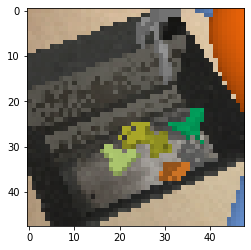

In [5]:
## The initial observation
plt.imshow(get_observation())

# Memory Buffer

A memory buffer is implemented to store the $(s, a, r, s')$ tuple so that once the buffer is filled enough the agent can sample data from the buffer and use an off-policy method to train on them.

The buffer is implemented using a deque. A deque has a capacity and when the duffer is filled, it will pop the oldes element to facilitate the newest element. 

the push method of the class adds new elements to the buffer and sample method randomly sample a set of buffer elements (number of elements to be sampled is defined using a batch size)

In [6]:
class ReplayBuffer:
    ## initialize the buffer
    def __init__(self, max_len):
        self.buffer = deque(maxlen=max_len)

    ## get buffer length
    def __len__(self):
        return len(self.buffer)

    ## append a sample of data to the buffer
    def push(self, experiance):
        self.buffer.append(experiance)
    
    ## sample data from the buffer
    def sample(self, batch_size):
        ## get a set of samples randomly
        batch_idx = np.random.choice(len(self.buffer), batch_size)
        state, action, reward, new_state = zip(*[self.buffer[idx] for idx in batch_idx])
        
        ## convert the state and new_state deques to a tensor
        ## converting the list to np array is a must, otherwise it
        ## introduces a bottleneck in performances
        state = torch.squeeze(torch.FloatTensor(np.array([state])), 0).to(device)
        new_state = torch.squeeze(torch.FloatTensor(np.array([new_state])), 0).to(device)

        ## convert the action batch to a tensor so it can gather
        action = torch.unsqueeze(torch.tensor(action), dim=1).to(device)

        ## convert rewards to tensor for bellman calculation
        reward = torch.tensor(reward).to(device)
        
        return state, action, reward, new_state

# Agent

The agent class has two major attributes, the policy network and the environment. When given an epislon value, the agent will perform either a random action (exploration) or an optimal action (exploitation) on the environment

the job of the agent as follows
* agent should perform an action
* When the action is from policy network, it is considered that the action belongs to the optimal policy $\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$
* agent should keep track of total reward for each episode so we know if the agent improves or not
* To optimise the policy network the predicted $Q(s,a)$ is compared against a true $Q_{true}(s,a)$. The $Q_{true}(s,a)$ is computed using the reward obtained from the environment and the target network (an old copy of the policy network)
\begin{align} Q_{true}(s,a) = r + \gamma max_{a} \hat Q(s',a')\end{align}
* Once the true labels of the Q function is computed, the estimated $Q(s,a)$ can be found using the temporal difference $\delta$
\begin{align}\delta = Q(s,a) - (r + \gamma max_{a} \hat Q(s',a')\end{align}
* Mean Squred Error is used as the loss function $L(\delta)$
* Finally the policy network can be optimized using one of the optimization algorithms (e.g. SGD, Adam, RMSprop)

In [7]:
class Agent:
    ## Initialize the agent
    def __init__(self, policy_net, env):
        ## keep track of frames for debugging
        self.step_counter = 0
        self.policy_net = policy_net
        self.env = env
        self.total_reward = 0.0
        self.env.reset()

    ## play a step
    def play_step(self, state, epsilon):
        done_reward = None
        ## increment the step counter
        self.step_counter += 1
        rnd = random.random()
        if rnd > epsilon:
            state = torch.unsqueeze(state, 0).to(device)
            #print(state.size())
            action = self.policy_net(state).max(1)[1].view(1,1)
            action = action.item()
        else:
            #print("random")
            action = self.env.action_space.sample()
        
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward
        ## check if the episode has ended
        if is_done:
            done_reward = self.total_reward
            self.total_reward = 0.0

        return action, done_reward, reward, new_state, is_done

    def compute_loss(self, tgt_net, batch):
        ## unpack the databatch
        state, action, reward, new_state = batch

        ## convert the state and new_state deques to a tensor
        ## converting the list to np array is a must, otherwise it
        ## introduces a bottleneck in performances

        ##to compute the loss we need Q(s,a) and Q(s`,a`)
        ## first get the Q(s,a) from the policy network
        ## then gather the values corresponds to target actions from the memory
        action_q_value = self.policy_net(state) \
                                            .gather(1, action.to(device)).squeeze(1)
        #print(action_q_value)

        ## Now find the Q(s`, a`)
        ## for this first we need to filter the done states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, new_state)))
        non_final_new_states = new_state[non_final_mask]
        ## now we use the target net and non final next state batch to get Q(s`, a`)
        ## detach the tensor from the graph to prevent gradients flowing to the
        ## target network
        next_state_q_value = torch.zeros(BATCH_SIZE, dtype=torch.float, device=device)
        next_state_q_value[non_final_mask] = tgt_net(non_final_new_states) \
                                                        .max(1)[0].detach()
        ## now find the Q(s,a)_target using bellman equation
        expected_q_value = reward + GAMMA * next_state_q_value
        
        ## compute the MSE loss
        loss = nn.SmoothL1Loss()(action_q_value, expected_q_value)
        return loss

    def optimize(self, optimizer, batch, tgt_net):
        ## init the optimizer
        ## we do this to prevent the gradients of one minibactch flowing
        ## to the next minibatch (pytorch accumilates gradients within a minibatch
        ## when you call loss.backward())
        optimizer.zero_grad()
        ## compute the loss
        loss = self.compute_loss(tgt_net, batch)
        ## compute gradients
        loss.backward()
        ## update parameters
        optimizer.step()

        ## return loss for monitoring
        return loss.item()

In [8]:
## GLOBALS
STACK_SIZE = 5
NUM_EPISODES = 100

MEAN_REWARD_BOUND = 50.0

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 500 #150#1000
REPLAY_START_SIZE = BATCH_SIZE

EPSILON_DECAY_LAST_FRAME = 10**4#10**5
EPSILON_START = 0.9 #1.0
EPSILON_FINAL = 0.1

MODEL_PATH = './models/kuka_2'
MODEL_NAME = 'kuka_policy_net.pt'
device = 'cuda'

In [9]:
## init a replay buffer
memory_buffer = ReplayBuffer(REPLAY_SIZE)

## init the DQN networks (both policy and target nets)
input_shape = [STACK_SIZE, 48, 48]
#print(input_shape)
policy_net = dqn_model.DQN(input_shape, env.action_space.n).to(device)
target_net = dqn_model.DQN(input_shape, env.action_space.n).to(device)
## copy the policy net weights to target net
target_net.load_state_dict(policy_net.state_dict())

## define the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

## init an agent
agent_dqn = Agent(policy_net, env)

## reward vars
ten_rewards = 0.0 ## reward for 10 episodes
total_rewards = list() ## total 
best_mean_reward = None
update_counter = 0

In [10]:
## convert a RGB image to gray and min max normalize them
def convert_to_gray(color_state):
    return cv2.cvtColor(color_state, cv2.COLOR_BGR2GRAY) / 255.0

In [11]:
while True:
    update_counter += 1
    ## get the training loss for an episode
    episode_loss = list()
    current_state = env.reset()
    ## convert to gray scale
    current_state = convert_to_gray(current_state)
    ## deq the initial frames as a stak defined by STACK_SIZE
    current_state_stack = deque([current_state] * STACK_SIZE, maxlen=STACK_SIZE)
    
    while True:
        ## Do the epsilon decay
        epsilon = max(EPSILON_FINAL, EPSILON_START - update_counter / EPSILON_DECAY_LAST_FRAME)
        current_state_tensor = torch.FloatTensor(current_state_stack)
        ## let the agent take an action
        action, done_reward, reward, _, is_done = agent_dqn.play_step(
                                                            current_state_tensor, epsilon)
        new_state = get_observation()
        if not is_done:
            ## make new state stack from the current states
            new_state_stack = current_state_stack
            ## add the new state as the last element in the stack
            ## so the stack now pops the oldest element
            new_state_stack.append(convert_to_gray(new_state))
            ## update the buffer
            memory_buffer.push((current_state_stack, action, reward, new_state_stack))
        else:
            new_state_stack = None
        
        if done_reward is not None:
            total_rewards.append(done_reward)
            #print(reward)
            mean_reward = np.mean(total_rewards[-100:]) * 100.0
            num_played_games = len(total_rewards)
            if best_mean_reward is None or best_mean_reward < mean_reward:
                ## update the best mean reward
                best_mean_reward = mean_reward
                if best_mean_reward is not None:
                    print("Best mean reward: {}".format(best_mean_reward))
                    SAVE_PATH = os.path.join(MODEL_PATH, str(num_played_games)+'_'+MODEL_NAME)  
                    torch.save(policy_net.state_dict(), SAVE_PATH)
            break

        ## make the current state the new state
        current_state_stack = new_state_stack
        ## check if we have enough data in the memory buffer
        if len(memory_buffer) < REPLAY_START_SIZE:
            continue
        
        ## if there are enough data we sample a batch
        train_batch = memory_buffer.sample(BATCH_SIZE)
        loss = agent_dqn.optimize(optimizer, train_batch, target_net)
        episode_loss.append(loss)

        ## We update the target net at each SYNC_TARGET_FRAMES
        if update_counter % SYNC_TARGET_FRAMES == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
    if best_mean_reward>50:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                                                update_counter+1, best_mean_reward))
        break

Best mean reward: 0.0
Best mean reward: 20.0
Best mean reward: 25.0
Best mean reward: 33.33333333333333
Best mean reward: 34.0
Best mean reward: 35.0
Best mean reward: 36.0
Best mean reward: 37.0
Best mean reward: 38.0
Best mean reward: 39.0
Best mean reward: 40.0
Best mean reward: 41.0
Best mean reward: 42.0
Best mean reward: 43.0
Best mean reward: 44.0
Best mean reward: 45.0
Best mean reward: 46.0
Best mean reward: 47.0
Best mean reward: 48.0
Best mean reward: 49.0
Best mean reward: 50.0
Best mean reward: 51.0
Environment solved in 2241 episodes!	Average Score: 51.00
